In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
import nltk

In [10]:
# Download necessary NLTK data
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\syeda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# Read in the data
df = pd.read_excel('../data/Maersk_Supply_Combined.xlsx')
df = df[(df['EBS1'].notna()) & (df['EBS1'] != ' ')]
df['EBS1'] = df['EBS1'].apply(lambda x: x.strip())

In [12]:
# Create a separate status list which we will use as labels
status = list(df['EBS1'])

# Create a df which contains the columns we will use for prediction
df = df[['Object', 'Group', 'Object_Type', 'Directive', 'Work_Description', 'Completion_Note']]

# Fill the N/A cells, lowercase the dataframe, and combine columns and create a combined column
df = df.fillna('')
for col in df.columns:
    df[col] = df[col].str.lower()
df['combined'] = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=1).tolist()

In [13]:
# Replace the carriage return characters with a space
for col in df.columns:
    df[col] = df[col].str.replace('_x000d_\n', ' ', regex=False)

# Lemmatization and stopword removal
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [14]:
def nltk_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif nltk_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def preproces_text(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, nltk_pos(tag)) if nltk_pos(tag) else token for token, tag in tagged_tokens]
    cleaned_token = [token for token in lemmatized_tokens if token not in stop_words and token.isalpha()]
    return ' '.join(cleaned_token)

# Apply our lemmatization code and lower case our combined column
df['combined'] = df['combined'].apply(preproces_text)
df['combined'] = df['combined'].str.lower()

In [15]:
# Create our vectorizer
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=20000, stop_words='english')

encoder = LabelEncoder()
encoder.fit(status)
encoded_labels = encoder.transform(status)

# Split the data into its constituent parts (description and status) and then create a prediction
X = df['combined']
X_vec = vectorizer.fit_transform(X)

# Train test split
X_train, X_valid, y_train, y_valid = train_test_split(X_vec, encoded_labels, test_size=0.2, random_state=30)

# Create XGBoost Model (scale_pos_weight determined by neg class/pos class)
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    learning_rate=0.05,
    n_estimators=2000,
    max_depth=10,
    min_child_weight=3,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=30,
    eval_metric='mlogloss'
)

# Eval and fitting of the initial model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

Accuracy: 94.16%
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.99      0.99      0.99       120
           6       0.89      0.80      0.84        30
           8       0.95      0.99      0.97        76
           9       0.00      0.00      0.00         4
          10       0.40      0.67      0.50         3
          11       0.50      0.50      0.50         2
          12       1.00      1.00      1.00        17
          13       0.83      0.91      0.87        11
          16       0.96      0.97      0.96        91
          17       1.00      1.00      1.00         2
          20       0.75      1.00      0.86         3
          22       0.00      0.00      0.00         1
          24       0.88      1.00      0.93        14
          26       1.00      0.96      0.98        28
          

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and b

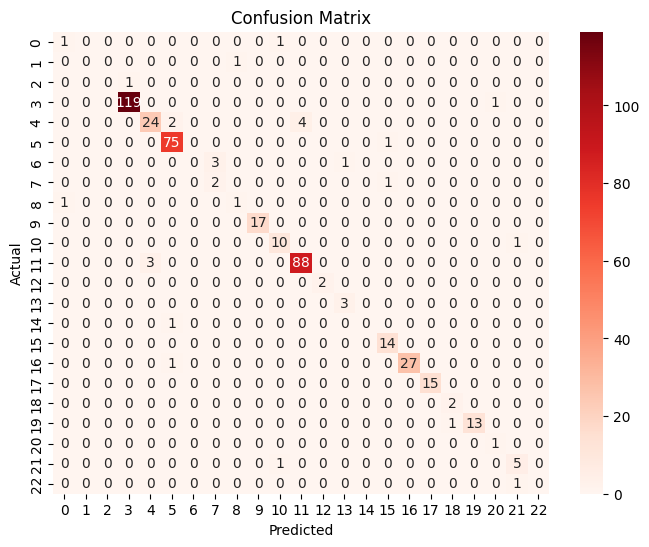

In [16]:
yp = xgb_model.predict(X_valid)
# Check the model accuracy
accuracy = accuracy_score(y_valid, yp)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Create an output that describes the individual statistics of the variables
valid_array = np.array(y_valid)
target_names = np.unique(valid_array)
print(classification_report(valid_array, yp, labels=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_valid, yp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()